# Importing Libraries

In [1]:
import torch 
from torch import nn 
from torch.optim import Adam 
import librosa
from torch.utils.data import Dataset, DataLoader 
from sklearn.preprocessing import LabelEncoder 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import os
import shutil
import time 
from skimage.transform import resize 

device = "cuda" if torch.cuda.is_available() else "cpu"

# Loading Data

In [2]:
df = pd.read_csv('ESC-50-master/meta/esc50.csv')

df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [3]:
len(df["category"].unique())

50

ESC-50 has 50 different classes. But for simplicity I'm taking ESC-10 which has 10 classes

## Filter out ESC-10

In [4]:
df = df[df['esc10'] == True].reset_index(drop=True)

print(df['category'].unique())

['dog' 'chainsaw' 'crackling_fire' 'helicopter' 'rain' 'crying_baby'
 'clock_tick' 'sneezing' 'rooster' 'sea_waves']


In [5]:
len(df["category"].unique())

10

In [6]:
audio_dir = 'ESC-50-master/audio'
save_dir = 'esc10_dataset'
os.makedirs(save_dir, exist_ok=True)

for _, row in df.iterrows():
    class_name = row['category']
    filename = row['filename']
    
    class_dir = os.path.join(save_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    src = os.path.join(audio_dir, filename)
    dst = os.path.join(class_dir, filename)
    
    shutil.copy(src, dst)


### Creating file_paths.csv to later use it in custom dataset class

In [7]:
dataset_dir = 'esc10_dataset'
data = []

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_dir, file_name)
                data.append({'FilePath': file_path, 'Class': class_name})

df_paths = pd.DataFrame(data)
df_paths.to_csv('file_paths.csv', index=False)

In [8]:
df_paths.head()

,FilePath,Class
0,esc10_dataset\chainsaw\1-116765-A-41.wav,chainsaw
1,esc10_dataset\chainsaw\1-19898-A-41.wav,chainsaw
2,esc10_dataset\chainsaw\1-19898-B-41.wav,chainsaw
3,esc10_dataset\chainsaw\1-19898-C-41.wav,chainsaw
4,esc10_dataset\chainsaw\1-47250-A-41.wav,chainsaw


# Exploration

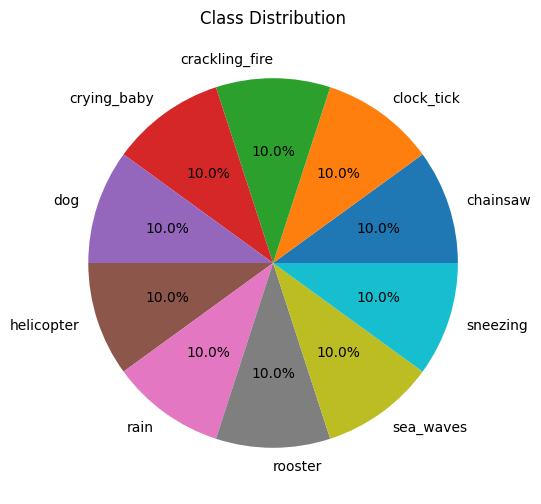

In [9]:
plt.figure(figsize=(6, 6)) 

plt.pie(df_paths['Class'].value_counts(), labels=df_paths['Class'].value_counts().index, autopct='%1.1f%%')

plt.title('Class Distribution') 
plt.show() 

# Preprocessing

In [10]:
label_encoder = LabelEncoder()
df_paths["Class"] = label_encoder.fit_transform(df_paths["Class"])

In [11]:
train = df_paths.sample(frac=0.7, random_state=7)
test = df_paths.drop(train.index)

val = test.sample(frac=0.5, random_state=7)
test = test.drop(val.index)

print("Training Shape: ", train.shape)
print("Validation Shape: ", val.shape)
print("Testing Shape: ", test.shape)

Training Shape:  (280, 2)
Validation Shape:  (60, 2)
Testing Shape:  (60, 2)


##### PyTorch Dataset Preprocessing Tasks

| Inside `Dataset` Class *(per-sample, at runtime)* | Outside `Dataset` Class *(once for full dataset)* |
|------------------------------------------------------|-----------------------------------------------------|
| Load files (e.g., image, audio)                     | Read CSV or metadata                                |
| Apply transforms (e.g., resize, crop)               | Train/test split                                    |
| Create features (e.g., spectrogram)                 | Label encoding                                      |
| Normalize per sample                                | Compute global mean/std                             |
|                                                    | Clean or filter data                                |



# Custom Dataset Class

In [12]:
class CustomAudioDataset(Dataset):
  def __init__(self, dataframe):
    self.dataframe = dataframe
    self.labels = torch.Tensor(list(dataframe["Class"])).type(torch.LongTensor).to(device)
    self.audios = [torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]     # --- In dataframe, that FilePath colum which corresponds to the audio
    label = torch.Tensor(self.labels[idx]).to(device)
    audio = (self.audios[idx]).unsqueeze(0).to(device)    # --- this is the actual audio itself which was loaded in __init__
    return audio, label      # -- here we are only returning Pectrogam and class label

  def get_spectrogram(self, file_path):
    sr = 22050  

    img_height = 128
    img_width = 256

    signal, sr = librosa.load(file_path, sr=22050)

    spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)

    spec_db = librosa.power_to_db(spec, ref=np.max)

    spec_resized = librosa.util.fix_length(spec_db, size = sr // 512 + 1)
    spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
    spec_resized = (spec_resized - np.mean(spec_resized)) / (np.std(spec_resized) + 1e-9)
    return spec_resized

### Creating Dataset Objects

In [13]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

# Hyperparameters

In [14]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

# DataLoaders

In [15]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [16]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1) # First Convolution layer
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1) # Second Convolution layer
    self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1) # Third Convolution layer
    self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
    self.relu = nn.ReLU() # ReLU Activation function

    self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
    self.linear1 = nn.Linear((64 * 16 * 32), 4096) # Traditional Dense (Linear)
    self.linear2 = nn.Linear(4096, 1024) # Traditional Dense (Linear)
    self.linear4 = nn.Linear(1024, 512) # Traditional Dense (Linear)
    self.output = nn.Linear(512, len(df_paths['Class'].unique())) # Output Linear Layer

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv1(x) # -> Outputs: (16, (128, 256))
    x = self.pooling(x)# -> Outputs: (16, (64, 128))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv2(x) # -> Outputs: (32, (64, 128))
    x = self.pooling(x) # -> Outputs: (32, (32, 64))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv3(x) # -> Outputs: (64, (32, 64))
    x = self.pooling(x) # -> Outputs: (64, (16, 32))
    x = self.relu(x)
    x = self.dropout(x)
    x = x.view(x.size(0), -1)

    x = self.flatten(x)

    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)


    x = self.linear4(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

model = Net().to(device) 


print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Model Summary

In [17]:
from torchsummary import summary 
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
           Dropout-4          [-1, 16, 64, 128]               0
            Conv2d-5          [-1, 32, 64, 128]           4,640
         MaxPool2d-6           [-1, 32, 32, 64]               0
              ReLU-7           [-1, 32, 32, 64]               0
           Dropout-8           [-1, 32, 32, 64]               0
            Conv2d-9           [-1, 64, 32, 64]          18,496
        MaxPool2d-10           [-1, 64, 16, 32]               0
             ReLU-11           [-1, 64, 16, 32]               0
          Dropout-12           [-1, 64, 16, 32]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                 [-

# Loss and Optimizer

In [18]:
criterion = nn.CrossEntropyLoss() 
optimizer = Adam(model.parameters(), lr=LR)

# Training and Validation

In [19]:
total_loss_train_plot = [] # Empty list to be filled with train loss after each epoch
total_loss_validation_plot = [] # Empty list to be filled with validation loss after each epoch
total_acc_train_plot = [] # Empty list to be filled with train accuracy after each epoch
total_acc_validation_plot = [] # Empty list to be filled with validation accuracy after each epoch


for epoch in range(EPOCHS):
  model.train()
  start_time = time.time() # We use this to calculate the time of each epoch, it starts a counter once called
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()
    optimizer.zero_grad()

  model.eval()
  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train / len(train_loader), 4))
  total_loss_validation_plot.append(round(total_loss_val / len(val_loader), 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  epoch_string = f"""
                  Epoch: {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)}, Train Accuracy: {round((total_acc_train/train_dataset.__len__() * 100), 4)}, 
                  Validation Loss: {round(total_loss_val/100, 4)}, Validation Accuracy: {round((total_acc_val/val_dataset.__len__() * 100), 4)}
                  """
  print(epoch_string)


                  Epoch: 1/25, Train Loss: 0.4795, Train Accuracy: 15.7143, 
                  Validation Loss: 0.0872, Validation Accuracy: 23.3333
                  

                  Epoch: 2/25, Train Loss: 0.4119, Train Accuracy: 22.8571, 
                  Validation Loss: 0.0854, Validation Accuracy: 31.6667
                  

                  Epoch: 3/25, Train Loss: 0.3488, Train Accuracy: 31.0714, 
                  Validation Loss: 0.0821, Validation Accuracy: 36.6667
                  

                  Epoch: 4/25, Train Loss: 0.3154, Train Accuracy: 35.7143, 
                  Validation Loss: 0.0789, Validation Accuracy: 36.6667
                  

                  Epoch: 5/25, Train Loss: 0.2934, Train Accuracy: 43.5714, 
                  Validation Loss: 0.0755, Validation Accuracy: 36.6667
                  

                  Epoch: 6/25, Train Loss: 0.2622, Train Accuracy: 49.6429, 
                  Validation Loss: 0.0746, Validation Accuracy: 45.0
        

# Visualization

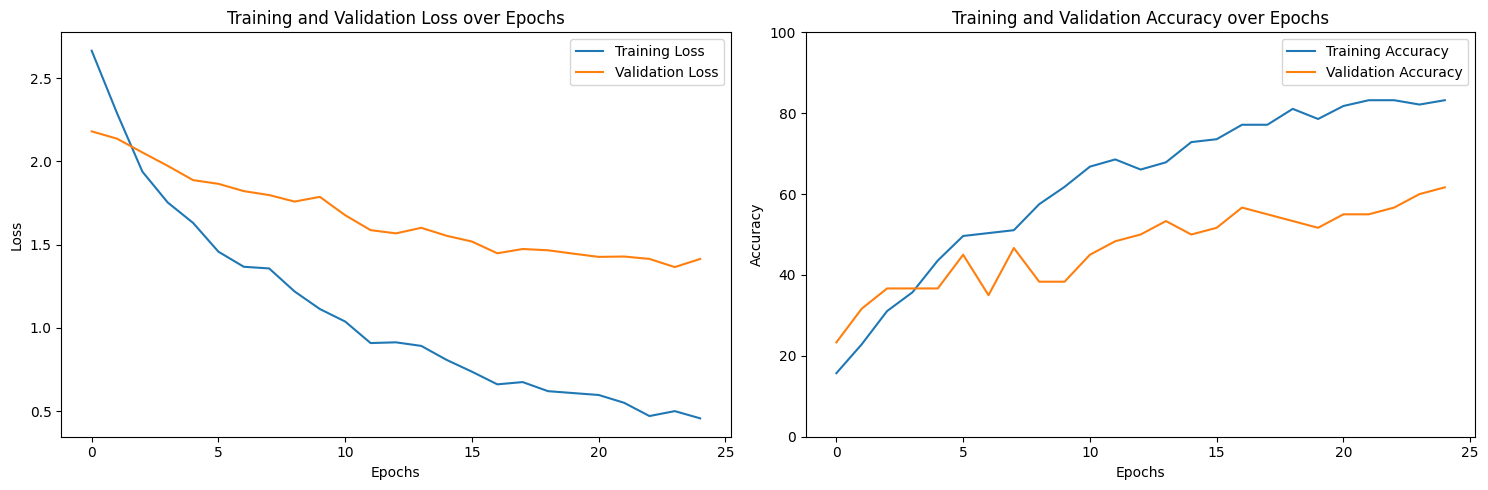

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

# Testing and evaluation

In [21]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 51.67%
